# **Homework 3 - Michelin restaurants in Italy**

*Group#20*

- **Marco Zimmatore** - [zimmatore.1947442@studenti.uniroma1.it](mailto:zimmatore.1947442@studenti.uniroma1.it)
- **Gabriele Cabibbo** - [cabibbo.2196717@studenti.uniroma1.it](mailto:cabibbo.2196717@studenti.uniroma1.it)
- **Emre Yeşil** - [1emreyesil@gmail.com](mailto:1emreyesil@gmail.com)
- **Emanuele Iaccarino** - [emanueleiaccarino.ei@gmail.com](mailto:emanueleiaccarino.ei@gmail.com)

___

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer
import contractions
from nltk.stem import WordNetLemmatizer
import re
import json
from collections import defaultdict
from DataCollection import engine 
import functions
import heapq

DEBUG:matplotlib:matplotlib data path: c:\Users\gabri\anaconda3\Lib\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:CONFIGDIR=C:\Users\gabri\.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is win32
DEBUG:matplotlib:CACHEDIR=C:\Users\gabri\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\gabri\.matplotlib\fontlist-v330.json
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **1. Data collection**

Although it would be ideal to call all functions together under ``` engine.py ``` and perform the parsing in a single step, this approach was not possible with our "more efficient" implementation. 

We’ll explore these issues later on, along with the solution implemented to address them.

Anyway I left ``` engine.py ``` file under DataColletion folder: the file works there but doesn't here on this Jupyter Notebook

### **1.1 Get the list of Michelin restaurants**

Fun Fact: I first did this part of the code 04/11/2024, the next day the number of restaurants was reduced from 2037 to 1983 (this is confirmed by the official site where now we have 100 pages instead of 102)

In [36]:
from DataCollection.crawler import get_michelin_urls
import logging
import time

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

start_time = time.time()
get_michelin_urls()
logging.info(f"Time to collect urls: {time.time() - start_time} seconds") # <3

DEBUG:root:Analyzing page 1
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): guide.michelin.com:443
DEBUG:urllib3.connectionpool:https://guide.michelin.com:443 "GET /en/it/restaurants/page/1 HTTP/1.1" 200 None
DEBUG:root:Analyzing page 2
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): guide.michelin.com:443
DEBUG:urllib3.connectionpool:https://guide.michelin.com:443 "GET /en/it/restaurants/page/2 HTTP/1.1" 200 None
DEBUG:root:Analyzing page 3
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): guide.michelin.com:443
DEBUG:urllib3.connectionpool:https://guide.michelin.com:443 "GET /en/it/restaurants/page/3 HTTP/1.1" 200 None
DEBUG:root:Analyzing page 4
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): guide.michelin.com:443
DEBUG:urllib3.connectionpool:https://guide.michelin.com:443 "GET /en/it/restaurants/page/4 HTTP/1.1" 200 None
DEBUG:root:Analyzing page 5
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): guide.mi

### **1.2 Crawl Michelin restaurant pages**

Using asyncio in the web scraping code allows to handle multiple HTML downloads concurrently, making the process faster and more efficient. Instead of waiting for each download to complete before starting the next (sequentially), the event loop jumps to the next available task when one is waiting for data, allowing to download multiple pages at the same time.

More info can be found [here](https://www.zenrows.com/blog/asynchronous-web-scraping-python#what-is-asynchronous-web-scraping), while the official Github repository is avaible at this [link](https://github.com/oxylabs/asynchronous-web-scraping-python)


 Apparently the reason why ``` engine.py ``` was working but calling here was not, is that jupyter run an event loop in the background that is not compatible with our asyncio library

In [37]:
from DataCollection.crawler import download_html_async

# I was having the following error: asyncio.run() cannot be called from a running event loop 
# solution was found here: https://community.openai.com/t/error-when-using-langchain-webresearchretriever-runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop/341969/5
# and here: https://github.com/googlecolab/colabtools/issues/3720
async def main(): # This allow us to run the function asynchronously
    await download_html_async() 

await main()

# Apparently the reason why engine.py was working but calling here was not, is that jupyter run an event loop in the background that is not compatible with our asyncio library

INFO:root:Downloading batch 1
INFO:root:Downloading batch 2
INFO:root:Downloading batch 3
INFO:root:Downloading batch 4
INFO:root:Downloading batch 5
INFO:root:Downloading batch 6
INFO:root:Downloading batch 7
INFO:root:Downloading batch 8
INFO:root:Downloading batch 9
INFO:root:Downloading batch 10
INFO:root:Downloading batch 11
INFO:root:Downloading batch 12
INFO:root:Downloading batch 13
INFO:root:Downloading batch 14
INFO:root:Downloading batch 15
INFO:root:Downloading batch 16
INFO:root:Downloading batch 17
INFO:root:Downloading batch 18
INFO:root:Downloading batch 19
INFO:root:Downloading batch 20
INFO:root:Downloading batch 21
INFO:root:Downloading batch 22
INFO:root:Downloading batch 23
INFO:root:Downloading batch 24
INFO:root:Downloading batch 25
INFO:root:Downloading batch 26
INFO:root:Downloading batch 27
INFO:root:Downloading batch 28
INFO:root:Downloading batch 29
INFO:root:Downloading batch 30
INFO:root:Downloading batch 31
INFO:root:Downloading batch 32
INFO:root:Downloa

In [38]:
# moves folders under same main folder for cleaness
from DataCollection.organize_folders import organize_folders
organize_folders()

Created main folder: michelin_restaurants
All page_* folders have been organized into the main folder.


### **1.3 Parse downloaded pages**

With the same method, we use asyncio for parsing, allowing to process multiple HTML files at the same time.
Additionally, the use of batches allow us to control the parallelism without overloading our sources, this way we analyze 100 files per batch. 

Smart and efficient way to perform it!

In [39]:
from DataCollection.parser import parse_all_restaurants
import asyncio
await parse_all_restaurants()

INFO:root:Starting to parse all restaurants.
DEBUG:root:TSV file header written.
INFO:root:Processing batch 1 with 100 files.
INFO:root:Processing batch 2 with 100 files.
INFO:root:Processing batch 3 with 100 files.
INFO:root:Processing batch 4 with 100 files.
INFO:root:Processing batch 5 with 100 files.
INFO:root:Processing batch 6 with 100 files.
INFO:root:Processing batch 7 with 100 files.
INFO:root:Processing batch 8 with 100 files.
INFO:root:Processing batch 9 with 100 files.
INFO:root:Processing batch 10 with 100 files.
INFO:root:Processing batch 11 with 100 files.
INFO:root:Processing batch 12 with 100 files.
INFO:root:Processing batch 13 with 100 files.
INFO:root:Processing batch 14 with 100 files.
INFO:root:Processing batch 15 with 100 files.
INFO:root:Processing batch 16 with 100 files.
INFO:root:Processing batch 17 with 100 files.
INFO:root:Processing batch 18 with 100 files.
INFO:root:Processing batch 19 with 100 files.
INFO:root:Processing batch 20 with 82 files.
INFO:root

In [40]:
import shutil
folder_path = "michelin_restaurants"
shutil.rmtree(folder_path)
print(f"The folder '{folder_path}' has been deleted successfully.")
# it's too heavy to push it and anyway we don't neeed it anymore 

The folder 'michelin_restaurants' has been deleted successfully.


In [41]:
from DataCollection.file_type_converter import tsv_to_csv
tsv_to_csv('michelin_restaurants_data.tsv', 'michelin_restaurants_data.csv')

Conversion complete: michelin_restaurants_data.csv


## **2. Search Engine**

___

### **2.0 Preprocessing**

#### **2.0.1 Preprocessing the Text**

In text analysis, raw data is often messy, inconsistent, and full of unnecessary details. Before diving into any meaningful analysis, we need to "clean" this text, transforming it into a format that is both consistent and relevant. This preprocessing step is essential—it reduces noise, helps algorithms focus on the core content, and improves accuracy in tasks like classification, sentiment analysis, and topic modeling. 

In [2]:
df = pd.read_csv("michelin_restaurants_data.csv")

**Setting Display Options:**

First, we configure Pandas to show all columns and rows without truncating the text. This makes it easier to verify each step in the process and ensures we don’t overlook any issues.

In [3]:
# Set options to display all columns, rows, and no truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

**Removing Stopwords:**

Stopwords are common words (like "the" and "is") that don’t add much meaning in analysis. By removing them, we highlight the important words that carry the actual message. Using NLTK’s English stopwords, we filter out these unnecessary terms, storing the result in a new column, no_stopwords.

In [4]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


df['no_stopwords']=df['description'].apply(functions.remove_stopwords)
print(df[['description', 'no_stopwords']].head())


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             description  \
0                                                                                                                           

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Removing Punctuation:**

Punctuation, while helpful for grammar, often doesn’t add analytical value. The remove_punc function removes it from our text, creating cleaner entries and making it easier to identify meaningful patterns in further analysis. The cleaned result is saved in no_stopwords_and_punct.

In [5]:
df['no_stopwords_and_punct'] = df['no_stopwords'].apply(functions.remove_punc)

print(df[['description', 'no_stopwords', 'no_stopwords_and_punct']].head())   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             description  \
0                                                                                                                           

**Stemming Words:**

Stemming reduces words to their root forms (like "running" to "run"). This generalization can improve the consistency of terms, especially in cases where we care about the concept of a word rather than its specific form. We apply this to the no_stopwords_and_punct column, saving the output as no_stpwrd_punc_and_stemmed.

In [6]:
df['no_stpwrd_punc_and_stemmed'] = df['no_stopwords_and_punct'].apply(functions.apply_stemming)

print(df[['description', 'no_stopwords_and_punct', 'no_stpwrd_punc_and_stemmed']].head())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             description  \
0                                                                                                                           

**Lemmatizing Words:**

Unlike stemming, lemmatization returns words to their actual dictionary form (e.g., "better" becomes "good"), which improves readability and consistency. We apply lemmatization to create a new column, lemmatized_text

In [7]:
df['lemmatized_text'] = df['no_stopwords_and_punct'].apply(functions.apply_lemmatization)
print(df[['description', 'no_stopwords', 'no_stopwords_and_punct', 'lemmatized_text']].head())


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             description  \
0                                                                                                                           

After I checked the results of Stemming  and lemmatizer, I prefer to use lemmatized's output. Because I realized that,Stemming caused same meaningless words. I think this method uses directly throw away same letters from end of the words. As a result, according to outputs of two methods I will contuinue with lemmatizer. (For example:restaurant>>>restaur)


**Removing Extra Spaces:**

As a side effect of all the text manipulations, extra spaces can appear, which disrupts the flow of clean data. We fix this with a regular expression to ensure neat, evenly spaced text.

**Removing Non-ASCII Characters and Emojis:**

Special characters and emojis often don’t add value in analysis, so we remove them by re-encoding text to ASCII. This keeps everything in a standard English character set, reducing noise.

**Expanding Contractions:**

Expanding contractions (like changing "don’t" to "do not") improves readability and clarity in text analysis, helping algorithms better understand the meaning. We apply this to make the text more complete and user-friendly.

**Removing URLs and Emails:**

URLs and emails are typically irrelevant to most types of text analysis, so we remove them to keep the text focused on the main content.

In [8]:
df['lemmatized_text+'] = df['lemmatized_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

df['cleaned_text'] = df['lemmatized_text+'].str.encode('ascii', 'ignore').str.decode('ascii')

df['cleaned_text'] = df['cleaned_text'].apply(lambda x: contractions.fix(x))

df['cleaned_text'] = df['cleaned_text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
df['cleaned_text'] = df['cleaned_text'].str.replace(r'\S+@\S+', '', regex=True)

**Standardizing Restaurant Names:**

Finally, we clean up restaurant_name by removing anything after a dash, leaving just the main name. This standardization is crucial for accurate grouping and comparison in analysis.

In [9]:
df['restaurant_name'] = df['restaurant_name'].str.split('–|-').str[0].str.strip()
df['restaurant_name'].head(5)

0                        O Me O Il Mare
1                        Alessandro Feo
2                                  Dama
3    Il Ristorante Alain Ducasse Napoli
4                         Palazzo Utini
Name: restaurant_name, dtype: object

### **2.1 Conjunctive Query** 

#### **2.1.1 Create Your Index!**

In this part of our project, we're creating a unique vocabulary and an inverted index for our restaurant descriptions. This approach helps us quickly look up which documents (or restaurant entries) contain specific terms, making search and retrieval much faster and more efficient. Here's a breakdown of each step:

  **Creating Unique Document IDs:**

*   We assign a unique document ID to each entry in our DataFrame by setting document_id equal to each entry's index. This gives each restaurant a distinct identifier, making it easy to refer back to specific entries later in our inverted index.



  **Initializing Vocabulary and Inverted Index:**

        

*   We set up an empty dictionary vocab to store unique terms (words) and their IDs. The current_term_id counter keeps track of the IDs as we assign them. We also initialize inverted_index, a dictionary that will map each term to a list of document IDs where that term appears.
 

  **Defining the get_term_id Function:**


*   The get_term_id function is crucial for building our vocabulary. It checks if a word already has an ID in vocab; if not, it assigns the next available ID to the word. This function ensures that each word has a unique ID, which we can use as a key in our inverted index.




        

  **Building Vocabulary and Inverted Index:**       
*   We then go through each restaurant’s description in the DataFrame. For each description, we:

  1.   Retrieve the document_id and split the cleaned text into individual words.
  2.   Use set(words) to get unique words, preventing duplicate entries of the same word in a single document.
  3.   For each unique word, we get or assign a term ID using get_term_id, then update our inverted_index to add the document_id to the list of documents associated with this term. This structure allows us to quickly retrieve all documents containing a given word.
        

  **Saving Vocabulary to CSV:**
*   Once our vocabulary is built, we save it to a CSV file called vocabulary.csv. This file provides a convenient reference for the terms and their IDs, which will be helpful for other tasks or for reloading the vocabulary later.
        
  **Saving the Inverted Index as JSON:**
*   We save the inverted_index as a JSON file. The JSON format preserves the dictionary structure and can be easily loaded later to quickly retrieve documents that contain specific terms.
        

  **Loading the Inverted Index and Vocabulary for Searches:**
*   Finally, we include commands to reload the inverted index and vocabulary. When we need to process a search query, we load inverted_index.json and vocabulary.csv to retrieve terms and their associated document IDs, making our search functionality efficient and ready to use.


In [10]:
# Create a unique document ID for each restaurant entry in the DataFrame
df['document_id'] = df.index  


vocab = {}
current_term_id = 0
inverted_index = defaultdict(list)  

# Function to get or assign a term ID
def get_term_id(word):
    """Assigns a unique ID to each word in the vocabulary."""
    global current_term_id
    if word not in vocab:
        vocab[word] = current_term_id
        current_term_id += 1  
    return vocab[word]  

for _, row in df.iterrows():
    doc_id = row['document_id']
    words = row['cleaned_text'].split()  
    unique_words = set(words)  

    for word in unique_words:
        term_id = get_term_id(word)
        inverted_index[term_id].append(doc_id)

# Convert the vocabulary dictionary to a DataFrame and save it to a CSV file for future reference
vocab_df = pd.DataFrame(list(vocab.items()), columns=['word', 'term_id'])
vocab_df.to_csv('vocabulary.csv', index=False)

# Save the inverted index as a JSON file to use later when processing queries
with open('inverted_index.json', 'w') as f:
    json.dump(inverted_index, f)

# Load the inverted index and vocabulary when we need to process a search query
with open('inverted_index.json', 'r') as f:
    inverted_index = json.load(f)

# Reload vocabulary from CSV into a dictionary
vocab_df = pd.read_csv('vocabulary.csv')
vocab = dict(zip(vocab_df['word'], vocab_df['term_id']))

#### **2.1.2 Execute the Query**

In this section, we create an inverted index and set up functions to process search queries. This allows us to efficiently retrieve restaurants based on keyword searches.

**Step 1: Save and Load the Inverted Index and Vocabulary**

1.  **Save the Inverted Index to JSON**

We save the inverted index to a JSON file for easy access when processing queries.

In [11]:
with open('inverted_index.json', 'w') as f:
    json.dump(inverted_index, f)

2.  **Load the Inverted Index and Vocabulary**

We load both the inverted index and vocabulary back into memory for query processing.

In [12]:
with open('inverted_index.json', 'r') as f:
    inverted_index = json.load(f)

vocab_df = pd.read_csv('vocabulary.csv')
vocab = dict(zip(vocab_df['word'], vocab_df['term_id']))

**Step 2: Query Preprocessing Function**

The preprocess_query function prepares a user's search query by removing punctuation and stopwords, converting each word into its unique term ID.

In [13]:
def preprocess_query(query):
    query = query.lower()
    query = re.sub(r'[^\w\s]', '', query)  
    query_terms = [word for word in query.split() if word not in stop_words] 
    term_ids = [vocab.get(word) for word in query_terms if word in vocab]
    return term_ids  

*  **Purpose:** This function cleans up a query by lowercasing, removing punctuation, and filtering out stopwords.
*  **Output:** The function returns a list of term IDs that represent the query words found in the vocabulary.

**Step 3: Search Function**

The search_restaurants function uses the term IDs from preprocess_query to find restaurants that contain all words in the query.

In [14]:
def search_restaurants(query):
    term_ids = preprocess_query(query)
    if not term_ids:
        print("No matching terms found in the vocabulary.")
        return pd.DataFrame()  

    matching_docs = set(inverted_index.get(str(term_ids[0]), []))  
    for term_id in term_ids[1:]:
        matching_docs.intersection_update(inverted_index.get(str(term_id), [])) 

    if matching_docs:
        results = df[df['document_id'].isin(matching_docs)][['restaurant_name', 'address', 'description', 'url']]
        return results.head(5)
    else:
        print("No documents match all query terms.")
        return pd.DataFrame()  

**Process:**

*    First, it preprocesses the query to get term IDs.
*    Then, it finds document IDs that contain all the query terms, using set intersections to narrow down the matches.

**Output:** If matching restaurants are found, it returns their details (name, address, description, and URL). If no matches are found, it either indicates no documents matched or returns an empty DataFrame.

It is an example command for trying commands and check the output.

In [15]:
# Example usage
query = "modern cuisine restaurant"
results = search_restaurants(query)
print(results)

                       restaurant_name  \
3   Il Ristorante Alain Ducasse Napoli   
11                          Donevandro   
22                         Quintogusto   
36               Il Luogo Aimo e Nadia   
37                              Dolada   

                                   address  \
3                Via Cristoforo Colombo 45   
11                         via Garibaldi 2   
22              piazza Sandro Pertini 54 r   
36                      via Montecuccoli 6   
37  via Dolada 21, località Plois alt. 870   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

### **2.2 Ranked Search Engine with TF-IDF and Cosine Similarity**

> Before going deep with the exercise, we wanna analyse and visualize the content of the restaurant descriptions and deepen the understanding of the dataset's domain. By using *WordClouds* (a Python library), we can gain insights into the most frequently occurring words within the text data. 


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\gabri\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\gabri\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\gabri\\anaconda3\\Lib\\site-packages\\matplotlib\\

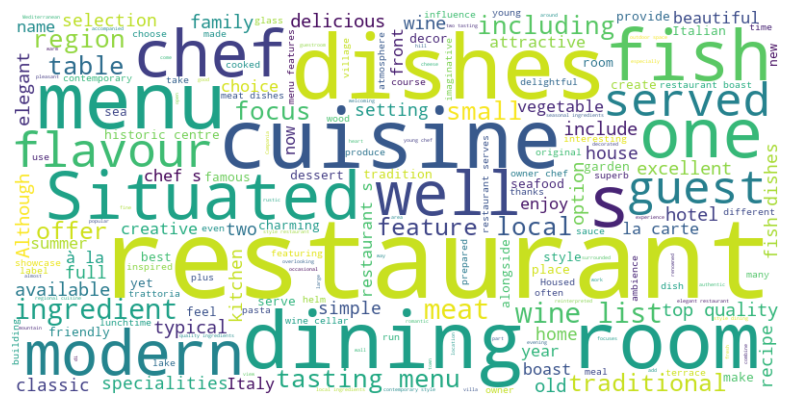

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# We create a umique string summarizing all the restaurants descriptions
text = " ".join(description for description in df['description'].dropna())

# Create the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Show WordCLoud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show();

- **Most Frequent Words**: The larger the word, the more frequently it appears in the dataset. 
- **Key Themes**: From the word cloud, we can see that the main themes are related to *restaurant*, *tastes*, and  reviews.
- **Stopwords Removed**: Common words like "the", "and", "is" have been excluded to focus on more meaningful terms, infact we dont need to preprocess the text

___
In this analysis, we use the **`CountVectorizer`** from scikit-learn purely for analytical purposes, infact later in the section we have developed our customed function to rank documents based on *cosine_similarity* above the **TF-IDF** scores. The *CountVectorizer* is used to extract bi-grams (sequences of two consecutive words) from the textual data in the **`description`** column of the dataset. We wanna underline the difference between the two histograms below where on the left we consider the *raw* description column, while on the right wewill consider the *preprocessed* description column. 


c:\Users\gabri\Desktop\LM-Data Science\Algorithmic Methods of Data Mining\ADM-HW3\functions.py:405: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(bigrams, rotation=90)
c:\Users\gabri\Desktop\LM-Data Science\Algorithmic Methods of Data Mining\ADM-HW3\functions.py:412: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(bigrams_preprocessed, rotation=90)
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\gabri\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.fo

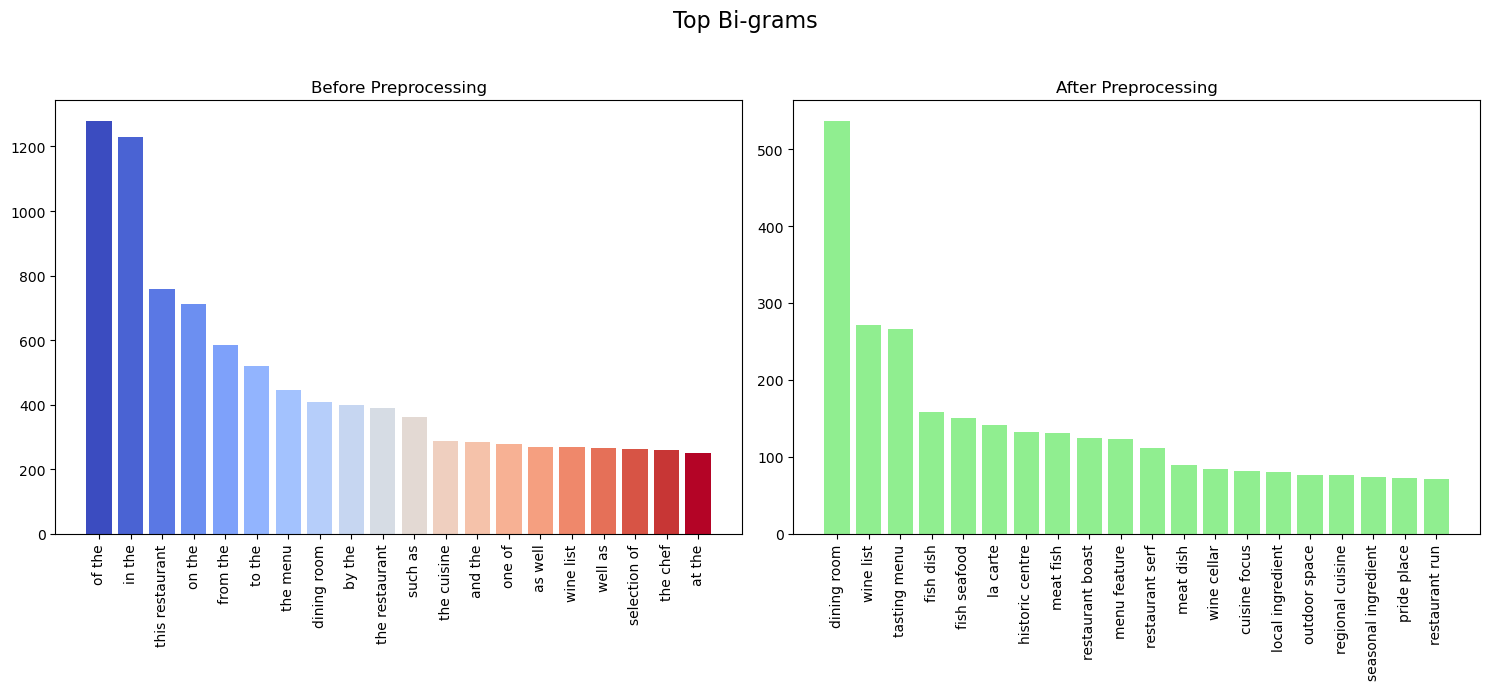

In [17]:
functions.visualize_frequency(df)

> We obviously can see that after the preprocessing steps and the using of `stop_words` argument into the initialization of the *CountVectorizer* the labels depicted change completely and better represent the key theme of the dataset 

#### **2.2.1 Inverted Index with TF-IDF Scores**

Before explaining the choices made, we have to underline that everything we've developed below could have been done using the *scikit-learn* module `TfidfVectorizer` and obtain the results we will append in the output file in fewer steps using the `fit_trasform` function on the *description* column of the dataframe.

1. **tfIdf Scores**: Calculate TF-IDF scores for each term in each restaurant’s description.


#### **What's the TF-IDF Score?**

> It is a function used in information retrieval to measure the importance of term in a document's collection.

It's composed by two factors:

- Given a term $i$ and a document $j$ we define the **Term Frequency** (*TF*) as $$tf_{i,j} = \frac{n_{i,j}}{d_j} $$ where $n$ is the number of occurences of that term $i$ in the document and $d$ is the lenght of the document $j$

- We define the **Inverted Document Frequency** (*IDF*) as: $$idf_i = \log_{10}(\frac{N}{|\{d: i \in d\}|})$$ where $N$ is the number of total documents in the collection while the denominator contains the number of documents that contain the term $i$

Then,  $$\text{tf-idf} = tf \times idf$$


> To compute the **TF-IDF** scores for each term in each restaurant description, at first we have to access to the *json* created in the 2.1 in order to iterate for each term and the DataFrame built on the *vocabulary.csv* file to map each *term_id* we find in the json file to a word used in the *description* column. 


In [18]:
# We create a copy of the dataframe because we dont want to change in place the original DataFrame
df_tfidf = df.copy()
# We store the words mapping in a DataFrame 
vocabulary = pd.read_csv("vocabulary.csv")

# We load in a Python dictionary the inverted_index creted previously
with open("inverted_index.json", 'r', encoding='utf-8') as file:
    inverted_index = json.load(file)


Once we have this three variables, we can execute the `update_inverted_index` function.

- To give a *tf-idf* index to each term, we wanna iterate over the previous inverted_index:
```python

        term_id, documents in inverted_index.items():

```
- We compute the **Inverted Document Frequency** (*IDF*), which is common for all the documents where the term appears:

```python

        documents_frequency = math.log(total_documents / (1 + len(documents)))
```

- We map each `term_id` to its word through the vocabulary DataFrame:

```python

        word = str(vocabulary.loc[vocabulary["term_id"] == int(term_id), "word"].iloc[0])

```

- We iterate over the list of `documents` where each *doc_id* is stored which is also the index to retrieve the correct document

- Then we compute the **Terms Frequency** (*TF*):

```python

        doc = df.iloc[int(doc_id)]["cleaned_text"]

        tf_score = doc.count(word) / (len(doc.split()))

```

- And we compute the IDF-TF score by multiplying the two terms (like we have said before):

```python

        idf_score = documents_frequency * tf_score
        
```
- Finally in the `inverted_index` dictionary we replace previous list of document_ids the list of tuples (*document_id*, *idf_score*) that associates to each document the corresponding idf_score



In [19]:
updated_inverted_index = functions.update_inverted_index(df_tfidf, inverted_index, vocabulary)

2. **Updated Inverted Index**: Build a new inverted index where each entry is a term, and the value is a list of tuples containing document IDs and TF-IDF scores.

> After having built the Updated version of the Inverted index in the previous step, we load it in a JSON file


In [20]:
with open("updated_inverted_index.json", "w") as file:
    json.dump(updated_inverted_index, file)


#### **2.2.2 Execute the Ranked Query**


1. Process the query terms.

> Given a raw query we use the functions previously defined to apply all the steps of preprocessing

In [21]:
query = "MODERN; Seasonal CUISINE. DISH"

# We create a Series from the query in order to apply the following functions 
query_series = pd.Series(query)

# We apply to the query the stemming, lemmatizations functions to prepare it 
query_series=query_series.apply(functions.remove_stopwords).apply(functions.apply_stemming).apply(functions.remove_punc).apply(functions.apply_lemmatization)
query_preprocessed = query_series.iloc[0]
query_preprocessed

'modern season cuisine dish'

> As we can see the query is normalized correctly

2. Use Cosine Similarity to rank matching restaurants based on the TF-IDF vectors of the query and each document.


#### **What's Cosine Similarity?**

- *Cosine similarity* is a metric used to measure how similar two vectors are, regardless of their magnitude.
$$\text{cosine similarity} = \frac{\vec{A} \cdot \vec{B}}{\|\vec{A}\| \|\vec{B}\|}$$
Where:
- $(\vec{A} \cdot \vec{B})$ is the dot product of the vectors.
- $|\vec{A}|$ and $|\vec{B}|$ are the magnitudes (norms) of the vectors.

In our case, we define the function `rank_documents` that takes as argument the *query* (preprocessed) the dictionary containing the `updated_inverted_index`. the DataFrame, the *vocabulary* dataframe, the integer *k* that selects the k best documents based on *cosine_similarity*.
We will carry out the process in 4 steps:

- **Compute TF-IDF Scores for the Query**:
   The function `compute_tfidf_query()` is used to calculate the TF-IDF scores for the given query based on the provided `inverted_index`, `df`, and `vocabulary`. This step results in a list of term IDs and their respective TF-IDF scores.

- **Construct Document Vectors**:
   The code iterates over the *term_ids* from the query and looks them up in the `inverted_index` to build TF-IDF vectors for each document containing those terms. The document vectors are stored in `document_tfidf`, with document IDs as keys and lists of term-score pairs as values.

- **Calculate Cosine Similarity**:
   For each document vector, the cosine similarity between the query vector and the document vector is computed. The results are stored as a list of tuples, where each tuple contains a document ID and its similarity score.

- **Rank and Select Top k Documents**:
   The documents are sorted based on their similarity scores in descending order. The top `k` documents are selected and stored in `documents_best_k`, which includes the `restaurant_name`, `address`, `description`, `url`, and their similarity scores. This final list is returned as the output.

In [22]:
k = 5  
similarities = functions.rank_documents(query_preprocessed, updated_inverted_index, df, vocabulary, k)

3. Return the top-k results or all matching restaurants if fewer than k have non-zero similarity.

In [23]:
similarities

,restaurant_name,address,description,url,similarity_score
1178,Arnaldo,piazza XXIV Maggio 3,"This restaurant was first awarded a Michelin star in 1959, which makes it the longest-held star (with a break of only two years) in Italy. Housed in a 15C palazzo next to the Aquila d'Oro hotel, the dining room boasts an atmospheric and nostalgic feel. The cuisine has the same traditional focus and celebrates Emilian traditions in all their glory, especially on the trolleys used to display selections of antipasti (sliced ham always features, as does spinach and cheese pie), and desserts (including a delicious zabaione served with pear in red wine and a creamy Sambuca semifreddo. But the undisputed stars of the show are the meat dishes, especially the two trolleys of specialities that are the highlight of any visit to Arnaldo. These include roast and boiled meats, including dishes not often found in a restaurant of this quality, such as calf’s head, tongue and pig’s trotters, all cooked traditionally and served with the usual sauces and gravies. Every morning, the “sfogline” pasta-makers prepare excellent fresh pastas, which are served either in a broth or simply with sage and butter. Arnaldo is not a place for fans of modern cuisine but if you’re keen to try authentic Emilian dishes full of flavour, you’ll be in your element here!",https://www.clinicagastronomica.com/,0.868943
296,Sissi,via Galilei 44,"Situated just outside the pedestrianised area of beautiful Merano, the main dining room of this restaurant has a welcoming feel and is decorated in attractive Art-Nouveau style. Here, owner-chef Andrea Fenoglio divides his time between the kitchen and front of house so that he can take time to chat with guests. His cuisine has solid classic foundations, with a good choice of dishes on the à la carte, plus a surprise tasting menu (Settepiatti ) which changes every year (as does the ceramic tableware on which it is served!). The cuisine is comforting and full of generous flavours, to which Fenoglio adds a light modern touch with his carefully chosen accompaniments and presentation. Whatever dish you choose, you can be sure of finding the perfect wine pairing for your meal on the skilfully constructed wine list.",https://sissi.andreafenoglio.com/it/home/1-0.html,0.862096
793,La Bandiera,contrada Pastini 4,"Although it takes a while to reach this restaurant that first opened in 1977, it is definitely worth the journey! Here, an entire family (second and third generations) works together with passion and enthusiasm to provide their guests with real gourmet hospitality. The cuisine, carefully planned and prepared by the parents alongside son Marcello, is based on a real respect for local, seasonal ingredients, some of which are produced by the family themselves (vegetables from the kitchen garden appear in nearly all the dishes, as does a home-produced extra-virgin olive oil). When it comes to technique, dishes have a modern feel, which makes the restaurant a flagship for top-quality Abruzzo cuisine. The couple’s other son, Alessio, works front of house and oversees the wine list, which includes impressive wine-pairing options. The excellent selection also includes a few pages of wines available by the glass, including top-of-the-range labels.",https://www.labandiera.it/,0.862096
1259,Don Alfonso 1890 San Barbato,"SS 93, km 56,300","Run by the Iaccarino family, who are renowned for their Mediterranean cuisine at Sant'Agata sui Due Golfi (some dishes from which feature on the menu here), this restaurant owes much to its talented chef Donato De Leonardis. His excellent cuisine includes regional influences with a hint of exotic flavour in dishes that are balanced, harmonious and often original without becoming excessively extravagant. The restaurant occupies the first floor of the luxury San Barbato Resort, which has a strong and committed approach to sustainable resource management. The modern, spacious dining room overlooks the illuminated foun

> We can see that all the terms we find in the input query are present in the descriptions displayed ordered by *cosine similarity*.

## **3. Define a New Score!**

___

1. **User Query**: The user provides a text query. We’ll retrieve relevant documents using the search engine built in Step 2.1.

In [24]:
query = "MODERN; Seasonal CUISINE. DISH"

query_series = pd.Series(query)
query_series=query_series.apply(functions.remove_stopwords).apply(functions.apply_stemming).apply(functions.remove_punc).apply(functions.apply_lemmatization)
query_preprocessed = query_series.iloc[0]
query_preprocessed

'modern season cuisine dish'

In [25]:
k = 5
df_query = functions.rank_documents(query_preprocessed, updated_inverted_index, df, vocabulary, k)

2. **New Ranking Metric**: After retrieving relevant documents, we’ll rank them using a new custom score. Instead of limiting the scoring to only the description field, we can include other attributes like `priceRange`, `facilitiesServices`, and `cuisineType`.

3. You will use a **heap data structure** (e.g., Python’s heapq library) to maintain the *top-k* restaurants.


### **New score**

Now we update the cosine similarity score to include cuisine type, the number of facilities and services and the price range.

\begin{align}
Score = Cuisine + \frac{(Cosine Similarity*log_2(Facilities+2))}{Price Range}
\end{align}

- *Cuisine*: Variable that take the value of 1 if the cuisine type in the query matches the cuisine type of the restaurant, otherwise it is set to 0. This penalizes a lot restaurants with that make cuisines different from the one that the user asked in the query or outside of it;

- *Facilities*: We take the base 2 logarithm of the number of facilities plus 2. This ensures that if the facilities asked don't match the facilities offered by the restaurant it's cosine similarity doesn't change, while it slowly increases the score if a user asks for more facilities and they're matched by the restaurant;

- Then we divide the product between the facility score and the cosine similarity by the numeric price range to decrease the score if the price range increases, in this way we promote more the restaurant that are most accessible.

In [26]:
query = 'MODERN; Seasonal CUISINE.'

query_preprocessed = pd.Series(query)
query_preprocessed = query_preprocessed.apply(functions.remove_stopwords).apply(functions.apply_stemming).apply(functions.remove_punc).apply(functions.apply_lemmatization)
query_preprocessed = query_preprocessed.iloc[0]

facilities_rq = ['Wheelchair access', 'Air Conditioning']
facilities_rq = pd.Series(facilities_rq)
facilities_rq = list(facilities_rq.apply(functions.remove_stopwords).apply(functions.apply_stemming).apply(functions.remove_punc).apply(functions.apply_lemmatization))

cuisine_type_rq = ['Modern']
cuisine_type_rq = pd.Series(cuisine_type_rq)
cuisine_type_rq = list(cuisine_type_rq.apply(functions.remove_stopwords).apply(functions.apply_stemming).apply(functions.remove_punc).apply(functions.apply_lemmatization))

functions.rank_new_score(query_preprocessed, updated_inverted_index, df, vocabulary, facilities_rq, cuisine_type_rq, k=5)

,restaurant_name,address,description,website,score
0,Sintesi,viale dei Castani 17,"A modern, welcoming restaurant whose motto “Tradition & Innovation” perfectly sums up its cuisine. On the à la carte and tasting menus alike you’ll find classic dishes including risotto with peas, lemon and raw scampi alongside more creative offerings such as grilled pannicolo (hanger steak) with Nemi strawberries and herbs, all presented in a modern and precise manner, and with the occasional nod to Asian techniques and northern European culinary methods (fermentation, marinades, dry aging of fish etc). The wine list changes with the seasons and the menu.",http://ristorantesintesi.it,1.2887
1,San Giorgio,viale Brigate Bisagno 69r,"Situated in the city albeit not right in the centre, San Giorgio is a typical Genovese restaurant – elegant and classic in style, with excellent cuisine served by the Scala family who have been in charge for decades. Young chef Samuele Di Mauro is at the helm, having started here as an apprentice and worked his way to the position of sous-chef and then head chef in 2022. Despite a focus on modern presentation and techniques, as demonstrated in dishes such as the raw bluefin tuna seasoned with an intense verbena mousse and served with caper cream and a “caviar” of dried and fried tuna, his cuisine is Mediterranean in style, with its roots in Ligurian aromas and flavours. The wine list is as impressive as the cuisine, with an entire section dedicated to French and Italian sparkling wines.",https://www.ristorantesangiorgiogenova.it/,1.2752
2,Esplanade,via Lario 3,"One of Italy’s long-established restaurants, the Esplanade has been a proud holder of a Michelin star since 1992 and is so renowned among food-lovers that its name is practically synonymous with that of Desenzano del Garda. Boasting a superb location alongside the lake, from which it is separated only by its own garden (the summer outdoor space is delightful), it is equally famous for its top-quality cuisine. The menu is one of the most extensive (at this level) in Italy, with an equal balance of meat and fish, and Italian and regional dishes prepared using mainly seasonal ingredients – this is classic Italian cuisine that does not stray too far from its traditional roots yet with delicate modern touches added by chef Massimo Fezzardi. The dining room, where the attentive service is as precise as a metronome, is overseen by two superb characters, namely Marzio Lee Vallio, the sommelier who won the 2024 Michelin Guide Italy Sommelier Award, and the exuberant and flawless Emanuele Signorini, a true professional whose friendly manner is contagious.",https://www.ristorante-esplanade.com/,1.2048
3,Seta Sushi Restaurant,corte Isolani 2,"It was friendship and passion for Japanese cuisine that prompted two young business partners to open this quiet, welcoming restaurant in the heart of Bologna. Situated in a courtyard with medieval origins, Seta Sushi Restaurant has a modern bistro-style dining room, as well as plenty of outdoor space for summer dining. The menu features an impressive selection of traditional Japanese dishes with the occasional personalised touch, all made from top-quality ingredients. Don’t worry if you’re new to Japanese cuisine – Maurilio is front of house to offer guests friendly, expert advice on both food and beverage. The latter includes a choice of sake for those wishing to immerse themselves fully in the Japanese dining experience.",http://www.setasushirestaurant.com,0.4095
4,La Leggenda dei Frati,costa San Giorgio 6/a,"After an uphill approach if you’re arriving here on foot, you come into the Villa Bardini museum complex and from there into this elegant and welcoming restaurant which provides the setting for delicious, creative and modern cuisine. Here, chef Filippo Saporito, never one to rest on his laurels, continues to experiment and perfect his cuisine, which focuses mainly on Italian culinary traditions and a scrupulous selection of top

In [27]:
restaurants = ['http://ristorantesintesi.it', 'https://www.ristorantesangiorgiogenova.it/', 'https://www.gucciosteria.com/it/florence', 'http://www.setasushirestaurant.com', 'https://www.sanbrite.it/']
filtered_df = df[df['url'].isin(restaurants)][['restaurant_name', 'price_range', 'facilities_services', 'cuisine_type', 'url']]
filtered_df

,restaurant_name,price_range,facilities_services,cuisine_type,url
887,San Giorgio,€€€,"Air conditioning, Interesting wine list, Wheelchair access","Modern Cuisine, Ligurian",https://www.ristorantesangiorgiogenova.it/
937,Gucci Osteria da Massimo Bottura,€€€€,"Air conditioning, Terrace","Italian Contemporary, International",https://www.gucciosteria.com/it/florence
1079,Seta Sushi Restaurant,€€,"Air conditioning, Terrace",Japanese,http://www.setasushirestaurant.com
1154,SanBrite,€€€€,"Air conditioning, Car park, Great view, Terrace, Wheelchair access","Alpine, Modern Cuisine",https://www.sanbrite.it/
1602,Sintesi,€€€,"Air conditioning, Car park","Contemporary, Seasonal Cuisine",http://ristorantesintesi.it


#### **Comparison between results with Cosine Similarity and results with our score**

Retrieving restaurants with the query "*MODERN; Seasonal CUISINE*" and using the cosine similarity to rank them and ranking them with our score results in different outcomes.

- "*Sintesi*" is still the the restaurant with the highest score since it matches the cuisine type and the facility "Air Conditioning", same with "*San Giorgio*" that matches the facility "Wheelchair access" too and has the same price range as "*Sintesi*", but it has a smaller cosine similarity;

- "*Gucci Osteria da Massimo Bottura*" gets penalized a lot for its high price range and gets ranked last and it doesn't even match the cuisine type;

- "*SanBrite*" moves up in the ranking because it matches both of the facilities asked.

So, the ranking retrieved using our score are better because they succeed in taking into account the user's requests for cuisine type and facilities and they make more visible more accessible restaurants against those that are more expensive.

## **4. Visualizing the Most Relevant Restaurants**

___

Geocode Locations were already parsed when scraping the HTML files, since the info was contained in the webpage and could be extracted using REGEX on the link that connected to Google Maps

In [12]:
!pip install folium


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Why Folium

We chose **Folium** due to its simplicity, flexibility, and all the integration avaible.

### Key Benefits of Using Folium
- **Interactive Maps**: Allows users to zoom, pan, and explore different locations dynamically.
- **Customization**: Supports adding custom markers, color coding, and popups to display detailed information.
- **Plugin Integration**: Folium supports various plugins that enhance interactivity

For more details: **[Folium Documentation](https://python-visualization.github.io/folium/)**.

---

## Explanation of Folium Plugins Used


### 1. MarkerCluster

The MarkerCluster plugin groups nearby markers into clusters, which expand to show individual markers as the user zooms in. It prevents overcrowding of markers on the map on high density area.

**Documentation**: [MarkerCluster Documentation](https://python-visualization.github.io/folium/latest/user_guide/plugins/marker_cluster.html)

---

### 2. MiniMap

The MiniMap plugin adds a mini-map to the right-bottom corner of the main map, helping users orient themselves within the broader region.

**Documentation**: [MiniMap Documentation](https://python-visualization.github.io/folium/latest/user_guide/plugins/mini_map.html)

---

### 3. HeatMap

The HeatMap plugin creates a heat map overlay that highlights areas with a high concentration of restaurants.

**Documentation**: [HeatMap Documentation](https://python-visualization.github.io/folium/latest/user_guide/plugins/heatmap.html)

---

### 4. MeasureControl

The MeasureControl plugin adds a tool to measure distances directly on the map. 

**Documentation**: [MeasureControl Documentation](https://python-visualization.github.io/folium/latest/user_guide/plugins/measure_control.html)

---

### 5. LocateControl

The LocateControl plugin adds a button that centers the map on the user’s current location.

**Documentation**: [LocateControl Documentation](https://python-visualization.github.io/folium/latest/user_guide/plugins/locate_control.html)


In [ ]:
import folium
import pandas as pd
from folium.plugins import MarkerCluster, HeatMap, MiniMap, MeasureControl, LocateControl

def create_restaurant_map(csv_file, output_map="restaurants_map.html"):
    data = pd.read_csv(csv_file)
    
    data['latitude'] = pd.to_numeric(data['latitude'], errors='coerce')
    data['longitude'] = pd.to_numeric(data['longitude'], errors='coerce')
    
    data = data.dropna(subset=['latitude', 'longitude'])
    
    # to center the map
    avg_lat = data['latitude'].mean()
    avg_lon = data['longitude'].mean()
    
    # Initialize map 
    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=6, control_scale=True)

    # plugins
    marker_cluster = MarkerCluster().add_to(m) #group nearby markers to make it easier to explore the map (specially in high density zones)
    minimap = MiniMap().add_to(m) # improves navigation
    HeatMap([[row['latitude'], row['longitude']] for _, row in data.iterrows()]).add_to(m) # highlights areas with high concentrations of restaurants
    m.add_child(MeasureControl()) # tool to calculate distances directly on the map
    LocateControl().add_to(m) # to retrieve users current position

    # color mapping for price ranges
    price_color_mapping = {
        "€": "green",
        "€€": "blue",
        "€€€": "orange",
        "€€€€": "red"
    }
    
    # pop-up HTML for each restaurant so we can provide all the needed info when u click on it
    def create_popup_html(row):
        info = f"""
        <strong>{row['restaurant_name']}</strong><br>
        <em>{row['cuisine_type']}</em><br>
        <br><strong>Address:</strong> {row['address']}, {row['city']}, {row['postal_code']}, {row['country']}<br>
        <strong>Price Range:</strong> {row['price_range']}<br>
        <strong>Phone:</strong> {row['phone_number']}<br>
        <strong>Website:</strong> <a href="{row['url']}" target="_blank">{row['url']}</a><br>
        <strong>Description:</strong> {row['description']}<br>
        <br><strong>Opening Hours:</strong><br>
        <table style="width:100%; border:1px solid black;">
            <tr><td><strong>Monday</strong></td><td>{row['monday_hours']}</td></tr>
            <tr><td><strong>Tuesday</strong></td><td>{row['tuesday_hours']}</td></tr>
            <tr><td><strong>Wednesday</strong></td><td>{row['wednesday_hours']}</td></tr>
            <tr><td><strong>Thursday</strong></td><td>{row['thursday_hours']}</td></tr>
            <tr><td><strong>Friday</strong></td><td>{row['friday_hours']}</td></tr>
            <tr><td><strong>Saturday</strong></td><td>{row['saturday_hours']}</td></tr>
            <tr><td><strong>Sunday</strong></td><td>{row['sunday_hours']}</td></tr>
        </table><br>
        <strong>Facilities:</strong> {row['facilities_services']}<br>
        <strong>Credit Cards:</strong> {row['credit_cards']}
        """
        return info
    
    # markers
    for _, row in data.iterrows():
        lat, lon = row['latitude'], row['longitude']
        price_range = row['price_range']
        
        marker_color = price_color_mapping.get(price_range, "gray")
        
        # pop up to store info for each restaurant
        popup_html = create_popup_html(row)
        popup = folium.Popup(popup_html, max_width=300)
        
        # Create a marker for each restaurant
        folium.Marker(
            location=[lat, lon],
            popup=popup,
            tooltip_text = f"{row['restaurant_name']} - {row['price_range']} - {row['cuisine_type']}",
            icon=folium.Icon(color=marker_color, icon="cutlery", prefix="fa") # to make it more pretty I added cutlery icon from FontAwesome
        ).add_to(marker_cluster)
    
    #legend for price range
    legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 150px; height: 140px; 
                 background-color: white; border:2px solid grey; z-index:9999; font-size:14px;">
     <strong>Price Range Legend</strong><br>
     <i style="color:green; font-size:15px;">&#9679;</i> €<br>
     <i style="color:blue; font-size:15px;">&#9679;</i> €€<br>
     <i style="color:orange; font-size:15px;">&#9679;</i> €€€<br>
     <i style="color:red; font-size:15px;">&#9679;</i> €€€€<br>
     </div>
     '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    m.save(output_map)
    print(f"Map has been saved to {output_map}")

create_restaurant_map("michelin_restaurants_data.csv")


Map has been saved to restaurants_map.html


## **5. BONUS: Advanced Search Engine**

___

Before setting up the search engine, I would read dataset again. Because there could be some missing columns.

In [4]:
url="https://raw.githubusercontent.com/zimmy11/ADM-HW3/refs/heads/main/michelin_restaurants_data.csv"
dataset_bonus=pd.read_csv(url)


In [5]:
dataset_bonus.columns

Index(['restaurant_name', 'address', 'city', 'postal_code', 'country',
       'price_range', 'cuisine_type', 'description', 'facilities_services',
       'credit_cards', 'phone_number', 'latitude', 'longitude', 'monday_hours',
       'tuesday_hours', 'wednesday_hours', 'thursday_hours', 'friday_hours',
       'saturday_hours', 'sunday_hours', 'url_micheline', 'url'],
      dtype='object')

In the *url_micheline* column, the restaurant's region is embedded within the URL structure. For example, in a URL like "https://guide.michelin.com/en/campania/gragnan...", "campania" represents the restaurant's region. We extracted this part of the URL using a regular expression and saved it as a new column named *region*. Finally, we verified the result by displaying the *url_micheline* and *region* columns together.

In [6]:
dataset_bonus['region'] = dataset_bonus['url_micheline'].str.extract(r'https://guide\.michelin\.com/en/([^/]+)/')

# Verify the result
print(dataset_bonus[['url_micheline', 'region']])

                                          url_micheline               region
0     https://guide.michelin.com/en/campania/gragnan...             campania
1     https://guide.michelin.com/en/campania/marina-...             campania
2     https://guide.michelin.com/en/lombardia/cerves...            lombardia
3     https://guide.michelin.com/en/campania/napoli/...             campania
4     https://guide.michelin.com/en/emilia-romagna/n...       emilia-romagna
...                                                 ...                  ...
1981  https://guide.michelin.com/en/piemonte/borgoma...             piemonte
1982  https://guide.michelin.com/en/trentino-alto-ad...  trentino-alto-adige
1983  https://guide.michelin.com/en/liguria/badalucc...              liguria
1984  https://guide.michelin.com/en/piemonte/barbare...             piemonte
1985  https://guide.michelin.com/en/veneto/cortina-d...               veneto

[1986 rows x 2 columns]


In the *restaurant_name* column, additional information such as city and address is sometimes included after the actual restaurant name, separated by a hyphen *(-)*. To simplify this column, we used a command to split the text at the first hyphen and keep only the first part, which is the restaurant name. This way, the *restaurant_name* column now contains only the main name of each restaurant.

In [7]:
dataset_bonus['restaurant_name'] = dataset_bonus['restaurant_name'].str.split(' -').str[0]


In [ ]:
# Convert relevant columns to sets for easier filtering, ensuring each value is treated as a string
dataset_bonus['credit_cards'] = dataset_bonus['credit_cards'].apply(lambda x: set(str(x).split(',')) if pd.notna(x) else set())
dataset_bonus['facilities_services'] = dataset_bonus['facilities_services'].apply(lambda x: set(str(x).split(',')) if pd.notna(x) else set())

# Ensure columns are strings to avoid AttributeError
dataset_bonus['city'] = dataset_bonus['city'].fillna('').astype(str).str.lower()
dataset_bonus['restaurant_name'] = dataset_bonus['restaurant_name'].fillna('').astype(str).str.lower()
dataset_bonus['cuisine_type'] = dataset_bonus['cuisine_type'].fillna('').astype(str).str.lower()
dataset_bonus['price_range'] = dataset_bonus['price_range'].fillna('')

This code defines a function search_restaurants that lets users search for restaurants based on various criteria. Here’s a breakdown of what each part does:

1.  **Collecting User Inputs:**

*  We prompt the user to enter search criteria, including restaurant name, city, cuisine type, price range, regions, accepted cards, and services. Each input can be skipped by pressing Enter, making it flexible for partial searches.
*  We ensure each input is case-insensitive by converting it to lowercase and stripping whitespace to handle variations cleanly.

2.  **Filtering Logic:**

*  We iterate over each restaurant in dataset_bonus. For each restaurant, we check if it meets the user’s specified criteria:

    - City, Price Range: For these, we require an exact match between the input and the existing data.
    - Restaurant Name, Cuisine Type, Accepted Cards, Services: For these inputs, we allow partial matches, meaning the input values don't need to be an exact match, but must be contained within the existing data.

*  If a restaurant meets all the criteria, it’s added to the results list.

3. **Displaying Results:**

*  If any restaurants match the criteria, we display each result with formatted details, including the restaurant name, address, cuisine type, price range, and website.
*  If no matches are found, a message informs the user.
This function is a useful and user-friendly tool for finding restaurants that match specific preferences. The flexibility in criteria input and clear display of results enhance the overall experience.


After run the function, you can follow the instructions.

In

In [ ]:
def search_restaurants():
    restaurant_name = input("Enter restaurant name (or press Enter to skip): ").strip().lower()
    city = input("Enter city (or press Enter to skip): ").strip().lower()
    cuisine_type = input("Enter cuisine type (or press Enter to skip): ").strip().lower()
    price_range = input("Enter price range (€, €€, €€€) (or press Enter to skip): ").strip()
    regions = input("Enter regions separated by commas (or press Enter to skip): ").strip().split(',')
    regions = [region.strip().lower() for region in regions if region.strip()]  # Clean whitespace
    accepted_cards = set(input("Enter accepted cards separated by commas (or press Enter to skip): ").strip().split(','))
    accepted_cards = {card.strip().lower() for card in accepted_cards if card}  # Clean whitespace
    services = set(input("Enter services separated by commas (or press Enter to skip): ").strip().split(','))
    services = {service.strip().lower() for service in services if service}  # Clean whitespace

    results = []
    for _, restaurant in dataset_bonus.iterrows():
        if restaurant_name and restaurant_name not in restaurant.get("restaurant_name", "").lower():
            continue

        if city and city != restaurant.get("city", "").lower():
            continue

        if cuisine_type and cuisine_type not in restaurant.get("cuisine_type", "").lower():
            continue

        if price_range and price_range != restaurant.get("price_range", ""):
            continue

        if regions and restaurant.get("region", "").lower() not in regions:
            continue

        if accepted_cards and not accepted_cards.intersection(restaurant["credit_cards"]):
            continue

        if services and not services.issubset(restaurant["facilities_services"]):
            continue

        results.append({
            "restaurant_name": restaurant["restaurant_name"],
            "address": restaurant["address"],
            "cuisine_type": restaurant["cuisine_type"],
            "price_range": restaurant["price_range"],
            "website": restaurant["url_micheline"]
        })

    # Print results
    if results:
        print("\nSearch Results:")
        for result in results:
            print(f"Name: {result['restaurant_name'].title()}, Address: {result['address']}, Cuisine: {result['cuisine_type'].title()}, Price: {result['price_range']}, Website: {result['website']}")
    else:
        print("No restaurants found matching the criteria.")

# Run search function
search_restaurants()

No restaurants found matching the criteria.


## **Algorithmic Question (AQ)**
___

1. Write the pseudocode for an algorithm that solves this problem.


### **Overview**
The algorithm is designed to guide a robot that collects packages located on a grid, starting from the origin point (0,0). The robot can only move right ('R') or up ('U'). The goal is to collect all packages using the fewest moves while maintaining a lexicographically smallest path.


#### **Input**
- The number of test cases, `t`.
- For each test case:
  - The number of packages, `n`.
  - The coordinates `(x_i, y_i)` of each package.

#### **Output**
- For each test case, print "YES" followed by the smallest path if all packages can be collected, or "NO" if it is impossible.


### **Pseudocode**
- The idea behind the followed *pseudocode* is that we want to divide each problem into smaller problems. Instead of thinking about "How can we collect all the packages in the best way?", we can firstly solve the problem "How can i reach in the fastes way the next package?" and iterate over the packages.
- To develop this in the most efficient way, we have to sort the collection that will contain the coordinates of each package we are receiving in input, because we dont want to solve in the brute force way trying every path possible. To do that
we compute the distance between the origin and each of the coordinates and we sort them on this distance. 
- Then we compute the **Manhattan Distance** (or **L1 distance**) that helps up to compute the number of single steps from point A to point B:
$$ d = |x_1 - x_2| + |y_1 - y_2| $$
- We iterate over this number and in each iteration we decide to go up or right giving more value to the right because lexicographycally  $"R" < "U"$
- Finally return the Path scaling this idea

Here the pseudocode:

```python
    FOR each test_case FROM 1 TO t DO
      n = READ integer from input
      list_of_coordinates = []

      FOR each package FROM 1 to N DO
        coordinates = READ integers from input
        ADD coordinates to list_of_coordinates

      sorted_coordinates = sort(list_of_coordinates)

      FOR target_x, target_yy IN sorted_coordinates DO
        if target_x or target_y LESS THAN current_coordinates
          BREAK
          PRINT("NO")

        COMPUTE DISTANCE BETWEEN target_x, target_y AND current_coordinates

        FOR steps FROM 1 TO distance DO
          IF current_coordinate_x LESS THAN target_x 
            THEN MOVE RIGHT AND ADD "R" TO PATH
            CONTINUE

          ELSE IF current_coordinate_Y LESS THAN target_y
            THEN MOVE UP AND ADD "U" TO PATH

    RETURN PATH


```




Then we have implemented in python this solution using numpy package to make the sorting more efficient:

In [ ]:


with open("algorithmic_input.txt") as file:

    # Select the number of Test Cases
    t = int(file.readline().strip())
    # Iterate over the number fo test cases
    for _ in range(t):
        
        # Extract the number of Packages to collect
        number_packages = int(file.readline().strip())

        # Store all the input coordinate into the Numpy Array
        list_of_coordinates = np.array([tuple(map(int, file.readline().strip().split())) for _ in range(number_packages)] , dtype = int)

        # I compute the distance from the (0,0) point to sort the list
        distances = np.sqrt(list_of_coordinates[:, 0]**2 + list_of_coordinates[:, 1]**2)

        # I have used the argsort function in order to return the indices of the distances ordered in ascendent way
        sorted_indices = np.argsort(distances)

        # I return the list ordered
        sorted_coordinates = list_of_coordinates[sorted_indices]

        # Execute the function to return the smallest path given an array of sorted coordinates
        functions.compute_smallest_path(sorted_coordinates)

    




YES
RUUURRRRUU
NO
YES
RRRRUUU


2. Prove that your algorithm is correct.

To prove the correctness of our algorithm, which contains a loop, the best way to do it is applying the **Invariant of the Loop**.
It is a logic condition that remains true at the beginning and end of each iteration of a loop during the execution of an algorithm.
Showing that a loop has an invariant can help to prove that the loop behaves correctly and in general the correctness of the algorithm.

#### **Invariant of the Loop**

**Loop Invariant**: At the beginning of each iteration, the current_coordinate represents a point reachable from the origin using only "U" and "R" moves, and result contains a valid path from the origin to current_coordinate.

**Proof**:

- **Initialization**: The starting point is (0, 0), which is trivially reachable from the origin.

- **Maintenance**:
The algorithm checks if the next coordinate (`target_x`, `target_y`) can be reached using only "U" and "R". This is verified by checking that `target_x` is not less than `current_coordinate[0]` and `target_y` is not less than `current_coordinate[1]`.
If this condition fails, the algorithm outputs "NO" and terminates, proving that reaching all points in the list is impossible with the allowed moves.
If the condition holds, the algorithm updates current_coordinate and appends "R" and "U" moves accordingly, ensuring that only valid moves are added to result.

- **Termination**: The loop iterates over all coordinates in list. When it completes without triggering the "NO" condition, it implies that all coordinates were reachable from the previous position using only "U" and "R" moves.

**Conclusion**: The loop invariant holds true throughout each iteration, guaranteeing that result represents a valid path up to `current_coordinate`.

Obviously we can scale up the invariant also for the external loop over the number_of_packages to complete the proof.

___
3. Compute the time complexity of your algorithm in Big O notation. Break down the steps involved in the algorithm, and explain which parts contribute most to the overall time complexity.
___

To Compute the time complexity of the algorithm int the **BIG O** Notation we have to consider in the *worst case*  the operation in your algorithm that consumes the most execution time.

The *worst case* happens when we are able to collect all the packages in input, so there is no stopping condition.

Let's break down the steps in the algorithm.
We define $t$ as the number of `test cases` and $n$ as the number of `packages` our robot has to collect each test case $t$.

- So at first we have to execute a for loop to iterate over the `test cases` t, so everything we'll be describe below will be executed $t$ times:
    ```python
                            for _ in range(t):
    ```
    - Then we use a list comprehension (*python functionality*) to store all the coordinates of the `packages` for that test case:
    ```python
    list_of_coordinates = np.array([tuple(map(int, file.readline().strip().split())) for _ in range(number_packages)] ,dtype = int)
    ```
    - The previous instruction maps a series of $n$ tuples (`number of packages`) inside the numpy array, so the instruction 
    ```python 
                            tuple(map(int, file.readline().strip().split())) 
    ``` 
    - will be executed $n$ times.

    - The **fundamental instruction** of the algorithm, is:
    ```python 
                            sorted_indices = np.argsort(distances)
    ```
    - Infact, as we know in the worst case the most efficient **Sorting algorithms** based on comparisons like *Merge Sort* have a lower bound of $O(n\log(n))$

Even if the previous instruction consumes the most execution time, let's be specific in the calculus of complexity and dive in the remaining part of the code.

- the function `compute_smallest_path` takes in input the *list_of_sorted_coordinates* and outputs the smallest path to collect all the packages if it is possible:


    - Ignoring instructions of initialization we consider $O(1)$ computationally, we iterate over the input list of size $n$ that contains the coordinates of each package sorted by the distance to the origin:

```python 
                            for target_x, target_y in list:
``` 

- The *fundamental operation* in this function is this loop, that in the worst case will be executed $s_i$ times where $s_i$ is the single step distance between the i-th and i+1-th package. 

```python 
                            for _ in range(distance_from_next):

``` 

- If we call $p$ the number of total steps, $p =  \sum_{i=1}^{n} s_i $


So the algorithm will have time complexity equal to $O(t \times n\log(n)) + O(t \times p \times n)$



___
4. Ask an LLM tool (such as ChatGPT, Claude AI, Gemini, Perplexity, etc.) to evaluate the time complexity of your code using Big O notation. Is the assessment accurate? If it differs from your previous analysis, which would be correct? Please explain your reasoning.
___

> My prompt to *ChatGpt* was `"##CODE## evaluate the time complexity of this code using Big O notation "`.

This was the answer:

To analyze the time complexity of this code, let’s break down each section and determine the number of operations relative to $n$, where $n$ represents the number of packages.

#### 1. **Reading and Parsing Input**
   - **File Reading**: The code reads $t$ test cases from a file. For each test case, it reads the number of packages and coordinates.
   - **Parsing Coordinates**: Each coordinate pair is read and converted into an integer tuple, which is stored in a Numpy array. Parsing takes $O(n)$ time per test case since it reads $n$ coordinates, each in $O(1)$ time.
   
   **Time Complexity for Parsing Input**: $O(t \times n)$.

#### 2. **Calculating Distances**
   - For each coordinate, the distance from the origin $0,0$ is calculated using the Euclidean formula $\sqrt{x^2 + y^2}$.
   - Calculating the distance for each of the $n$ points takes $O(n)$ time, as computing the distance for each point is $O(1)$.

   **Time Complexity for Distance Calculation**: $O(t \times n)$.

#### 3. **Sorting Coordinates by Distance**
   - The code sorts the indices based on their distances from the origin. Sorting an array of $n$ elements takes $O(n \log n)$.
   - After sorting, the code creates a new array `sorted_coordinates` by rearranging the coordinates based on the sorted order, which is $O(n)$.

   **Time Complexity for Sorting**: $O(t \times n \log n)$.

#### 4. **Computing the Smallest Path**
   - The `compute_smallest_path` function iterates through each of the sorted coordinates in $O(n)$ time.
   - For each coordinate, it checks if the target coordinate can be reached by only moving "up" (U) or "right" (R). This involves a constant-time check and, if infeasible, it returns immediately.
   - If the target can be reached, the code calculates the distance along $x$ and $y$ axes.
   - For each coordinate, it adds the steps to reach it. Moving each step and updating coordinates takes $O(1)$, and each package requires a bounded number of steps (no more than $x + y$ operations per package).

   Overall, this is an $O(n)$ operation since it iterates through all coordinates once and performs a bounded amount of work for each coordinate.

   **Time Complexity for Smallest Path Calculation**: $O(t \times n)$.

#### 5. **Printing Results**
   - Printing “YES” or “NO” and the path string is $O(n)$ for each test case.

   **Time Complexity for Printing**: $O(t \times n)$.

#### **Total Time Complexity**

Summing up the complexities for each step, the dominant term is $O(t \times n \log n)$ from the sorting step. Thus, the overall time complexity is:

$$O(t \times n \log n)$$


where:
- $t$ is the number of test cases,
- $n$ is the number of packages per test case.

This complexity indicates that the code's performance primarily depends on the sorting operation within each test case.


 - I dont fully agree with the response give by *ChatGPT*. It has broken in small parts the calculus of time complexity like we have done, but it wasnt accurate in my opinion on the study of the algorithm `compute_smallest_path` because it has made the assumption that the size of the path $p$ is $O(1)$. 

- But if $p$ is $O(n)$ for example the **Total time complexity** is not $O(t \times \log(n))$ but it would be $O(t \times n^2)$ which would be the worst case because the function `compute_smallest_path` would consume the most amount of time.

5. Assume now that the robot can also move towards the left or downwards, and consider the greedy approach: from the current location go to the closest package. Notice that now we can always collect all packages. Prove that the greedy algorithm is optimal (i.e., it minimizes the total distance traveled), or provide a counterexample showing that it is not.   

The proof of optimality for this greedy approach relies on the optimal substructure of the problem. Specifically, we show that if the greedy choice is not optimal at some step, swapping the greedy move with an alternative will equalize or increase the total distance traveled. 

#### **Step-by-Step Analysis**: 

The algorithm is based on the calculus of the **Manhattan Distance** that minimizes by definition the number of single steps between two points.

**Initial State**: The robot starts at some position $(𝑥_0,𝑦_0)$ and is tasked with collecting a set of packages, each located at $( 𝑥_𝑖 , 𝑦_𝑖 )$.

**Greedy Step**: At each step, the robot moves to the closest package (because we have previously sorted the list of packages). 
Let’s assume the greedy algorithm at some stage goes from the current position $(x_k,y_k)$ to some package $( 𝑥_𝑞 , 𝑦_𝑞)$, and then from $(x_q ​ ,y_q ​ )$ to $(x_p ​ ,y_p ​ )$ selecting the closest package.

 Now, let’s consider an another algorithm alternative (not *greedy*) swapping the two steps: first move from $(x_k ​ ,y_k ​ )$ to $(x_p ​ ,y_p ​ )$, and then move from $( 𝑥_𝑝 , 𝑦_𝑝 )$ to $(x_q ​ ,y_q ​)$. 

 The total distance (equal to the **Manhattan Distance**) for the greedy choice is: $𝐷_{greedy} = |x_k − 𝑥_𝑝|+ |𝑦_𝑘 − 𝑦_𝑝| + |𝑥_𝑝 − 𝑥_𝑞| + |𝑦_𝑝 − 𝑦_𝑞|$

The total distance for the alternative choice is: $D_{alternative} ​ = ∣x_k ​− x_q ∣ + ∣y_k− y_q∣ + ∣x_q − x_p∣ + |y_q​ − y_p|$

The key observation here is that, by the triangle **inequality for Manhattan distance**, we have: 
$$ |x_k ​ −x_p ∣ + ∣y_k ​− y_p∣ + |𝑥_𝑝 − 𝑥_𝑞| + |𝑦_𝑝 − 𝑦_𝑞| \le ∣ x_k − x_q∣ + ∣y_k​ − y_q∣ + ∣x_q − x_p∣ + ∣y_q​ − y_p∣$$
Hence, moving directly from  $(x_k,y_k )$ to $(x_p,y_p)$ and then to $(x_q ,y_q)$ will not result in a greater distance than the alternative move. 
 
Therefore, the greedy approach (choosing the closest package at each step) is at least as good as any alternative strategy in terms of total distance.

For completeness, we have implemented also the function that simulates this extended case.

In [ ]:
import numpy as np 
import functions

with open("algorithmic_input.txt") as file:

    # Select the number of Test Cases
    t = int(file.readline().strip())
    # Iterate over the number fo test cases
    for _ in range(t):
        
        # Extract the number of Packages to collect
        number_packages = int(file.readline().strip())

        # Store all the input coordinate into the Numpy Array
        list_of_coordinates = np.array([tuple(map(int, file.readline().strip().split())) for _ in range(number_packages)] , dtype = int)

        # I compute the distance from the (0,0) point to sort the list
        distances = np.sqrt(list_of_coordinates[:, 0]**2 + list_of_coordinates[:, 1]**2)

        # I have used the argsort function in order to return the indices of the distances ordered in ascendent way
        sorted_indices = np.argsort(distances)

        # I return the list ordered
        sorted_coordinates = list_of_coordinates[sorted_indices]

        # Execute the function to return the smallest path given an array of sorted coordinates
        functions.extended_compute_smallest_path(sorted_coordinates)

    




YES
RUUURRRRUU
YES
RLU
YES
RRRRUUU


We can see that in this case we are able to collect all the packages, so "NO" is not printed in the output